In [1]:
# Fill in your names using the format below
your_name = "LAST_NAME, FIRST_NAME"
your_name2 = "LAST_NAME, FIRST_NAME"
your_name3 = "LAST_NAME, FIRST_NAME"
your_name4 = "LAST_NAME, FIRST_NAME"
your_name5 = "LAST_NAME, FIRST_NAME"
your_name6 = "LAST_NAME, FIRST_NAME"

# Assignment 2
The [Speed Dating dataset](https://www.openml.org/d/40536) collects feedback gathered from participants in experimental speed dating events. Every participant rated themselves and their dates according to different attributes (e.g. attractiveness, sincerity, intelligence, fun, ambition, and shared interests,...), and whether or not they were interested in a second date. Our goal is to build a machine learning model able to predict whether there will be a match (or not) between two different people. Will you be able to trust your final model?

In [2]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
start_time = time.time()

### Additional packages:
* Seaborn (plotting)
    - Run `pip install seaborn` or `conda install seaborn`

In [3]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import seaborn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.23.2"):
    print("scikit-learn is outdated. Please update now! pip install -U scikit-learn")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [4]:
# Download Speed Dating data. Takes a while the first time. Do not change this code!
# Note that X is a pandas dataframe 
dates = openml.datasets.get_dataset(40536)
X, y, _, feat_names = dates.get_data(target=dates.default_target_attribute)

In [5]:
# Cleanup. Do not change this code!
# Remove irrelevant or preprocessed columns 
cols = [c for c in X.columns if ((c.lower()[:2] != 'd_' or c.lower() == 'd_age') and c.lower() not in ['wave','has_null'])]
X = X[cols]
classes = ['No match','Match']

# Fix feature name typos
X = X.rename(columns={'ambtition_important': 'ambition_important',
                     'sinsere_o': 'sincere_o'})

# Harmonize the field names somewhat
X['field'] = X['field'].str.lower()
X = X.astype({'field': 'category'})

# Drop columns with more than 10% missing values
missing_counts = X.isnull().sum() * 100 / len(X)
d = {k:v for (k,v) in missing_counts.items() if v>10}
X.drop(d.keys(), axis=1, inplace=True)

# Solves an implementation issue with TargetEncoder
y=y.astype(int)

In [6]:
# THIS WILL BE HELPFUL
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [7]:
# Peek at the remaining data
X

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked,met
0,female,21.0,27.0,6.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.14,3.0,7.0,6.0,0.0
1,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.54,3.0,7.0,5.0,1.0
2,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.16,3.0,7.0,NaN,1.0
3,female,21.0,23.0,2.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.61,3.0,7.0,6.0,0.0
4,female,21.0,24.0,3.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.21,3.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,male,25.0,26.0,1.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.64,10.0,2.0,5.0,0.0
8374,male,25.0,24.0,1.0,European/Caucasian-American,Other,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.71,10.0,4.0,4.0,0.0
8375,male,25.0,29.0,4.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,-0.46,10.0,6.0,5.0,0.0
8376,male,25.0,22.0,3.0,European/Caucasian-American,Asian/Pacific Islander/Asian-American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.62,10.0,5.0,5.0,0.0


In [8]:
# Check the column data types and missing data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         8378 non-null   category
 1   age                            8283 non-null   float64 
 2   age_o                          8274 non-null   float64 
 3   d_age                          8378 non-null   float64 
 4   race                           8315 non-null   category
 5   race_o                         8305 non-null   category
 6   samerace                       8378 non-null   category
 7   importance_same_race           8299 non-null   float64 
 8   importance_same_religion       8299 non-null   float64 
 9   field                          8315 non-null   category
 10  pref_o_attractive              8289 non-null   float64 
 11  pref_o_sincere                 8289 non-null   float64 
 12  pref_o_intelligence            828

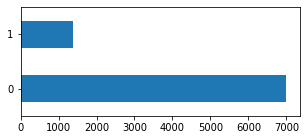

In [9]:
# Is the data balanced?
y.value_counts().plot(kind='barh', figsize=(5,2));

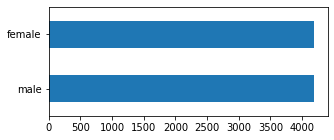

In [10]:
# See if some groups of people are more represented than others
X['gender'].value_counts().plot(kind='barh', figsize=(5,2));

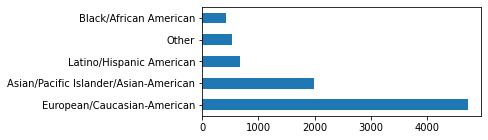

In [11]:
X['race'].value_counts().plot(kind='barh', figsize=(5,2));

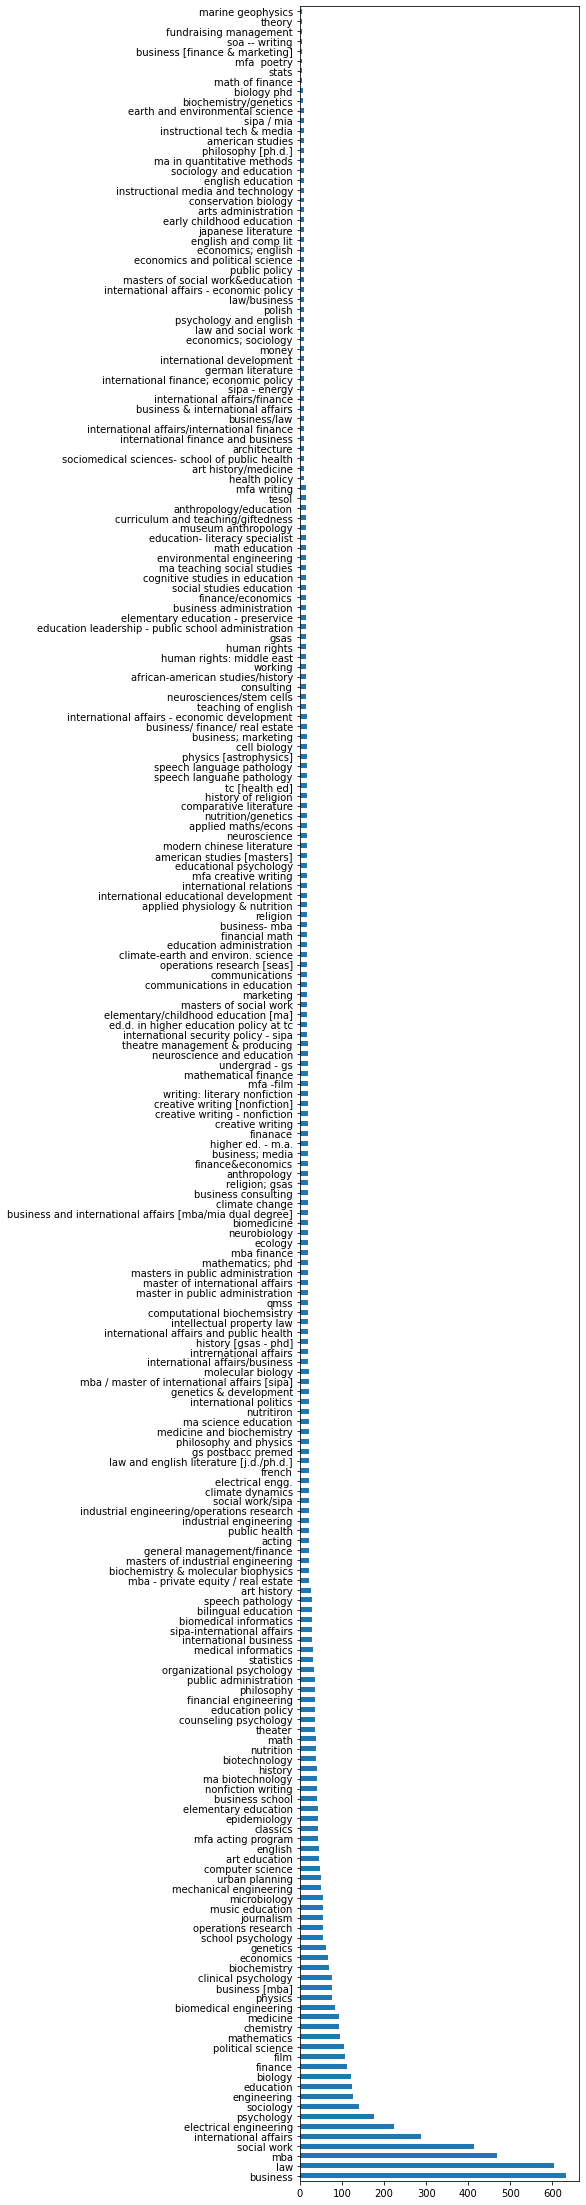

In [12]:
# Some categorical columns have a large number of possible values
# Note: It looks like some manual cleaning should be done, but let's move on
X['field'].value_counts().plot(kind='barh', figsize=(5,40));

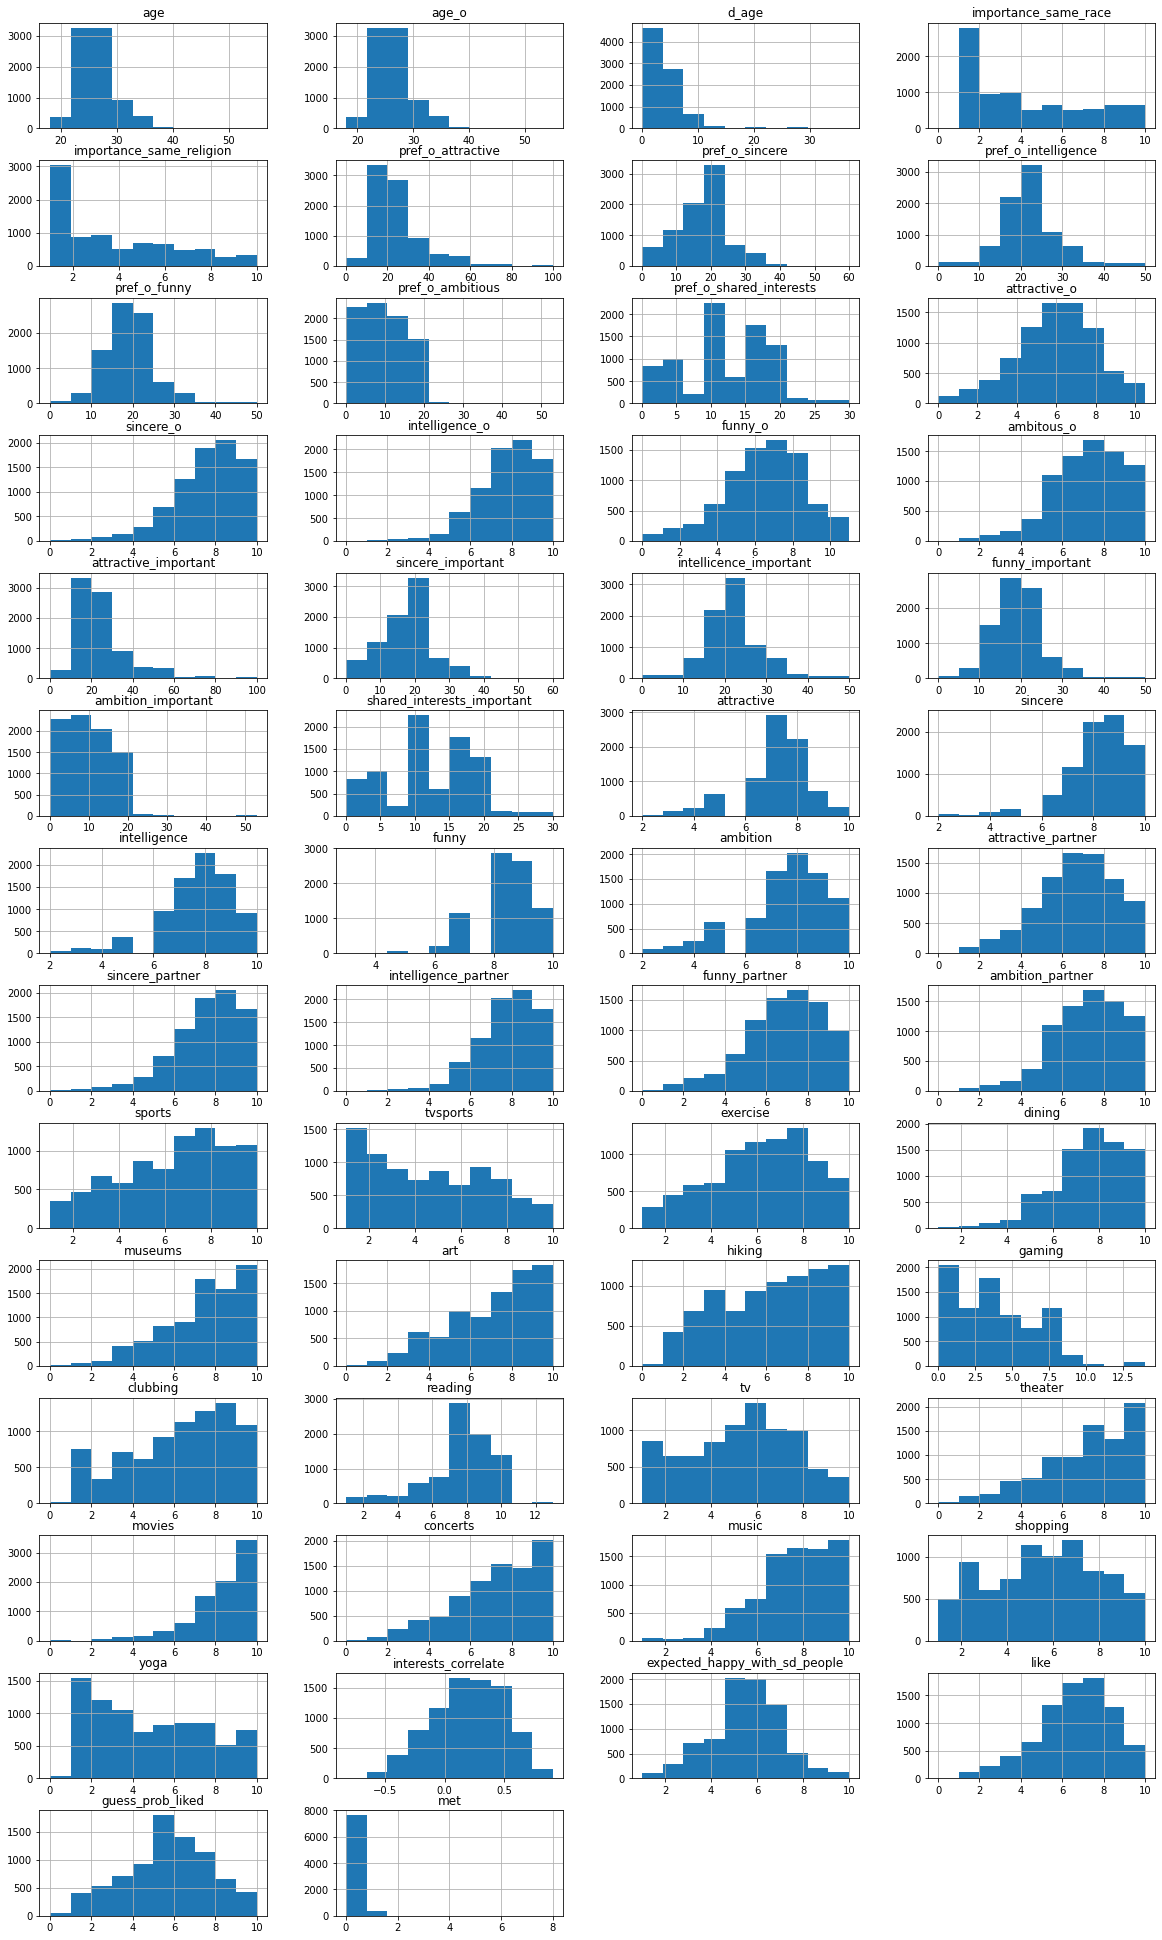

In [13]:
# Distributions of numeric data
X.hist(layout=(20,4), figsize=(20,50));

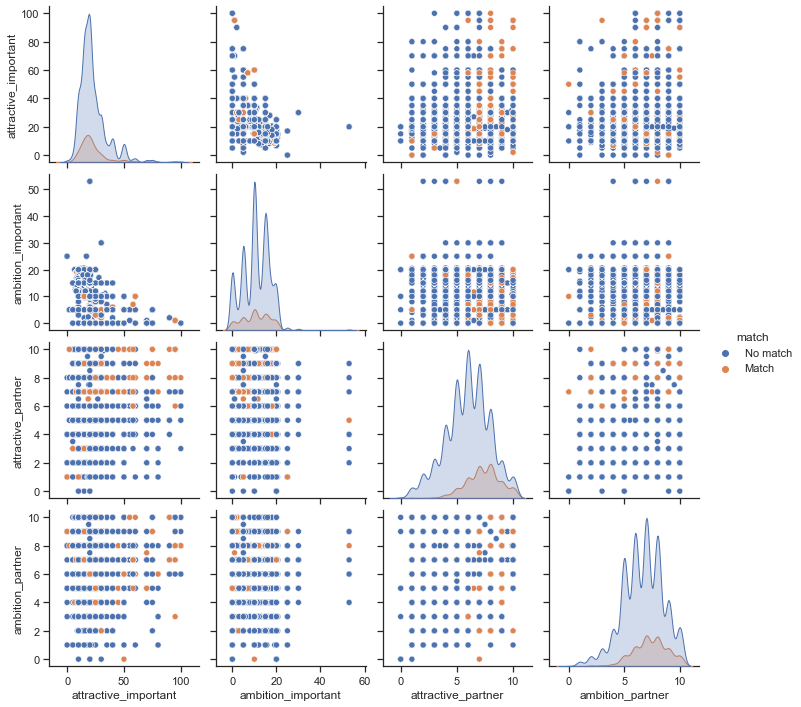

In [14]:
# What do people find important? Is this related to the outcome (match / no match)?
import seaborn as sns
subset = ['attractive_important','ambition_important','attractive_partner','ambition_partner']
X_sub=X[subset]
X_sub['match'] = [classes[int(x)] for x in y] 
sns.set(style="ticks")
sns.pairplot(X_sub, hue="match");

## Part 1: Preprocessing

### Question 1.1 (5 points)
Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a classifier:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Remove missing values by replace missing values with the mean value for that feature
    
Note that this function should not internally use any variables that are not passed as arguments.

In [15]:
# Implement
def simple_pipeline(X, clf):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    X -- The training data
    clf -- any scikit-learn classifier
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [16]:
### MODEL SOLUTION
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def simple_pipeline(X, clf):
    # Pipeline for categorical features
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))
    # Pipeline for numerical features
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    # Column transformer for both types of features. We use 'remainder' for the numerical ones.
    categorical = X.select_dtypes(include=["category"]).columns.tolist()
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

#### Sanity check
To be correct, this pipeline should be able to fit any classifier without error. Run this code to do a sanity check.

In [17]:
from sklearn.tree import DecisionTreeClassifier
simple_pipeline(X, DecisionTreeClassifier()).fit(X,y);

### Question 1.2 (1 point)
How many features are being constructed by this pipeline (i.e. on how many features is the classifier trained)?

In [18]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_2 = 0

In [19]:
### MODEL SOLUTION
pipe = simple_pipeline(X, DecisionTreeClassifier()).fit(X,y)
print("There are {} features".format(np.shape(pipe.named_steps['columntransformer'].transform(X))[1]))

# Extra: breakdown per type
# One-hot-encoding constructs a new feature per possible category 
print("numeric:",len(numerical))
for f in categorical:
    print("{}: {}".format(f,len(X[f].value_counts())))
    
q_1_2 = 287

There are 287 features
numeric: 54
gender: 2
race: 5
race_o: 5
samerace: 2
field: 219


### Question 1.3 (3 points)
Implement a function `flexible_pipeline` with allow you to add a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling

In [20]:
# Implement
from sklearn.preprocessing import StandardScaler
def flexible_pipeline(X, clf, scaler=StandardScaler()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The training data
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [21]:
### MODEL SOLUTION
def flexible_pipeline(X, clf, scaler=StandardScaler(), encoder=OneHotEncoder()):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),encoder)
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),scaler)
    categorical = X.select_dtypes(include=["category"]).columns.tolist()
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

### Question 1.4 (3 points)
Implement a function `plot_1_4` which plots a heatmap comparing several combinations of scaling methods and classifiers:
* As classifiers, the following algorithms in their default hyperparameters settings: 
    * SVM with RBF kernel
    * Random Forest
* As options, the following feature scaling options in their default settings:
    * No scaling
    * Standard scaling
    * PowerTransformer
* In all cases, use OneHotEncoder with `sparse=False` and `handle_unknown='ignore'`

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

In [22]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [23]:
# Implement
def plot_1_4(X, y):
    """ Evaluates 3 classifiers together with 4 types of scaling. See description above.
    """
    pass

In [24]:
### MODEL SOLUTION
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm

# Helper function to construct the score matrix
def heatmap_helper(X, y, classifiers, options):
    o_names = [o.__class__.__name__ for o in options]
    c_names = [c.__class__.__name__ for c in classifiers]
    scores = []
    # Always use the same stratified folds
    cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for o in tqdm(options, leave=False): 
        o_scores = []
        for c in tqdm(classifiers, leave=False):
            ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
            pipe = flexible_pipeline(X,c,scaler=o,encoder=ohe)
            cv_scores = cross_validate(pipe, X, y, cv=cvs, scoring='roc_auc')
            o_scores.append(np.mean(cv_scores['test_score']))
        scores.append(o_scores)
    heatmap(c_names, o_names, scores)

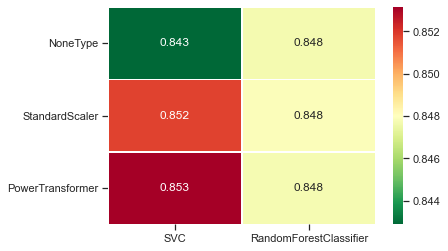

In [25]:
### MODEL SOLUTION
def plot_1_4(X, y):
    classifiers = [SVC(random_state=1),RandomForestClassifier(random_state=1)]
    options = [None, StandardScaler(), PowerTransformer()]
    heatmap_helper(X, y, classifiers, options)

plot_1_4(X, y)

### Question 1.5 (1 point)
Interpret the heatmap of Question 1.4. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': Scaling or not scaling makes no difference for any of the classifiers.
- 'B': Scaling is very important for both classifiers.
- 'C': Scaling is important for SVMs, but not needed for Random Forests.
- 'D': The default SVM with scaling performs better than the default Random Forest.
- 'E': The power transformer is much better than other techniques on this dataset because many features have a power law distribution.
- 'F': The power transformer about equally good as the standard scaler (performance difference is less than 1%)
- 'G': No answer

In [26]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_5 = 'C,D,F'

**Explanation**  
- A: Clearly not true for SVMs.
- B: Clearly not true for Random Forests.
- C: Correct. Trees are not affected by scaling.
- D: Yes. A larger ensemble would probably help, though.
- E: No. On this dataset it is mostly on par with the StandardScaler.
- F: Indeed. It is on par.

### Question 1.6 (3 points)

Perform a grid search for the SVM classifier. Range `C` on a log scale from 0.1 to 1000 (5 values), and `gamma` from 1e-4 to 1 (5 values).
Scale the data using standard scaling and use one-hot-encoding before passing the data to the SVM, and make sure that there is no data leakage. 
I.e. the test data must never be given to the preprocessings steps.

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation (more folds would be better, this is to save time). 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

Implement a function `plot_1_6` which plots a heatmap comparing the scores for all values of `C` and `gamma`. You can use the same heatmap function as before.

In [27]:
# Implement
def plot_1_6(X, y):
    """ Plots a heatmap for a grid search varying the C and gamma values for a scaled SVM
    """
    pass

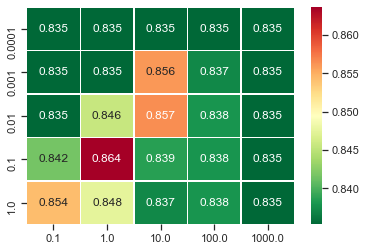

In [28]:
## MODEL SOLUTION
from sklearn.model_selection import GridSearchCV

def plot_1_6(X, y):
    """ Plots a heatmap for a grid search varying the C and gamma values for a scaled SVM
    """
    param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
                  'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ss = StandardScaler()
    pipe = flexible_pipeline(X,SVC(random_state=1),scaler=ss,encoder=ohe)
    cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) # Should be n_splits=5, but this speeds things up.
    # GridSearchCV with pipelines will make sure that there is no data leakage
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cvs, n_jobs=-1).fit(X,y)
    scores = grid.cv_results_['mean_test_score'].reshape(5, -1)
    heatmap(param_grid['svc__C'], param_grid['svc__gamma'], scores)
    
plot_1_6(X, y)

## Part 2: Feature importance

### Question 2.1 (5 points)
Implement a function `plot_2_1` that does the following:  
* Filter the input data X by gender. Gender in this dataset can be 'male' or 'female'
* Use your `flexible_pipeline`, without feature scaling but with one-hot-encoding, with a RandomForest classifier (1000 trees, 10% for max_features). Train that pipeline on the filtered input data
* Remember that the categorical features where encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`).
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Plot the model-based feature importances using the plotting function `plot_importances` below.

In [29]:
# Plotting function. Do not edit.
def plot_importances(importance, feature_names, top_k=40, title=""):
    """ Simple bar chart plottinh feature importances
    Keyword arguments:
    importance -- The feature importances 
    feature_names -- The original features names in their original order
    top_k -- How many features to plot
    """
    # Trees
    sorted_idx = importance.argsort()[-top_k:]
    fig, ax = plt.subplots(figsize=(6, 6))
    y_ticks = np.arange(0, top_k)
    ax.barh(y_ticks, importance[sorted_idx])
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(title)

    fig.tight_layout()
    plt.show()

In [30]:
# Implement
def plot_2_1(X, y, gender=''):
    """ Returns a plot of the most important features, where data is filtered by gender. See detailed description above.
    """
    pass
plot_2_1(X, y, gender='male')
plot_2_1(X, y, gender='female')

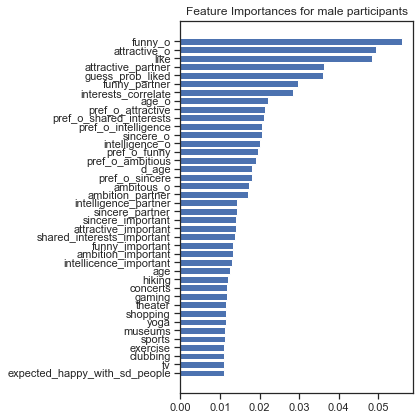

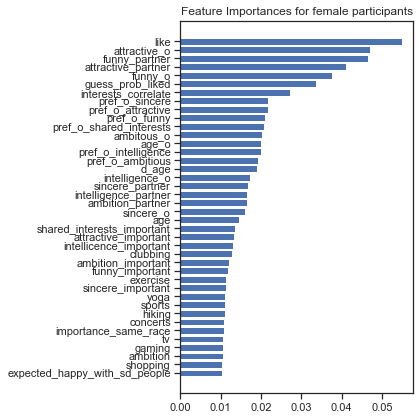

In [31]:
# MODEL SOLUTION
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Train RF
def plot_2_1(X, y, gender=''):
    #y=y.astype(int)
    # Filter data
    mask = X.gender==gender
    X_g = X[mask]
    y_g = y[mask]
    # Build and fit pipeline (on all data, we're not evaluating models here)
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    rf_pipe = flexible_pipeline(X_g, RandomForestClassifier(n_estimators=1000, max_features=0.1), scaler=None, encoder=ohe)
    rf_pipe.fit(X_g, y_g)
    # Get the feature names produced by the encoder
    enc = rf_pipe.named_steps['columntransformer'].named_transformers_['pipeline'].named_steps['onehotencoder']
    rf_cat_feature_names = enc.get_feature_names(input_features=categorical)
    rf_feature_names = np.r_[rf_cat_feature_names, numerical]
    # Get feature importances from the random forest
    rf_feature_importances = rf_pipe.named_steps['randomforestclassifier'].feature_importances_
    # Plot
    plot_importances(rf_feature_importances, rf_feature_names, title="Feature Importances for {} participants".format(gender))

plot_2_1(X, y, gender='male')
plot_2_1(X, y, gender='female')

### Question 2.2 (2 points)
Evaluate, using 5-fold cross-validation and AUC, 3 models:
- The model trained with all the data
- The model trained for male participants
- The model trained for female participants

In [32]:
from sklearn.model_selection import cross_val_score

mask = X.gender=='male'
X_male, y_male = X[mask], y[mask]
X_female, y_female = X[~mask], y[~mask]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
cv = cross_val_score(flexible_pipeline(X_male, SVC(random_state=1),encoder=ohe), X_male, y_male, scoring='roc_auc')
print("AUC for the male-specific model",np.mean(cv))

AUC for the male-specific model 0.809278764734201


In [33]:
cv = cross_val_score(flexible_pipeline(X_female, SVC(random_state=1),encoder=ohe), X_female, y_female, scoring='roc_auc')
print("AUC for the female-specific model",np.mean(cv))

AUC for the female-specific model 0.810438446922609


In [34]:
cv = cross_val_score(flexible_pipeline(X, SVC(random_state=1),encoder=ohe), X, y, scoring='roc_auc')
print("AUC for the general model",np.mean(cv))

AUC for the general model 0.8054620554906862


Interpret the results of Question 2.1 and 2.2. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': The matches for males and females are decided by the exact same features and the performane of all three models is the same.
- 'B': There are only slight differences in feature importance, and the per-gender models are only marginally (<1%) better.
- 'C': There are some important differences, and hence the per-gender models are significantly better. 
- 'D': There are siginificant differences in the feature importances, but this does not translate into better per-gender models.
- 'E': No answer

In [35]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_2_2 = 'B'

In the answer below, discuss whether you see a performance difference. Does it help to build separate models for males and females? Why (not)? Also relate this to the observed feature importance in question 2.1. Maximum 800 characters.

In [36]:
answer_q_2_2 = """
               Answer B is correct. Looking at the feature importances, there are a lot of commonalities. For males it is slightly more important that they are deemed funny (by the other person), 
               but the importance values are very close. For males, the age of the partner seems slightly more important. For both models, attractiveness is important. Overall, there are no big differences,
               and hence we don't expect that separate models will help much. Indeed, individual models for males and females are only marginally (0.5%) better than building one big model.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

Answer is 609 characters long


## Part 3: Calibrating predictions
### Question 3.1 (2 points)
Use a grid search to optimize the RandomForest pipeline from question 2.1. Vary the number of trees from 100 to 1500 (at least 4 values) and set `max_features` to either
0.05, 0.1, or 'auto' (sqrt(p)). Evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Plot the results in a heatmap in function `plot_3_1`.

In [37]:
#Implement
def plot_3_1(X, y):
    """ See detailed description above.
    """
    pass

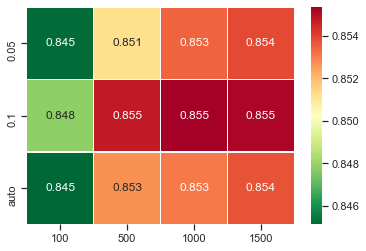

In [38]:
# MODEL IMPLEMENTATION
from sklearn.model_selection import GridSearchCV
def plot_3_1(X, y):
    param_grid = {'randomforestclassifier__n_estimators': [100, 500, 1000, 1500],
                  'randomforestclassifier__max_features': [0.05, 0.1, 'auto']}
    pipe = flexible_pipeline(X, RandomForestClassifier(), scaler=None, encoder=OneHotEncoder(sparse=False, handle_unknown='ignore'))
    cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cvs, scoring='roc_auc', n_jobs=-1).fit(X, y)
    scores = grid.cv_results_['mean_test_score'].reshape(3, -1)
    heatmap(param_grid['randomforestclassifier__n_estimators'], param_grid['randomforestclassifier__max_features'],scores)
plot_3_1(X, y)

### Question 3.2 (2 points)
Implement a function `plot_3_2` that plots the ROC curve for the Random Forest pipeline with `n_estimators=1000`.
Also indicate the point on the curve that corresponds to the 0.5 probability decision threshold.

In [39]:
#Implement
def plot_3_2(X, y):
    """ See detailed description above.
    """
    pass

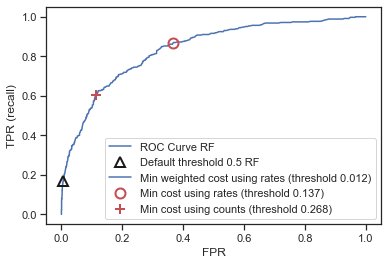

In [40]:
### MODEL SOLUTION
from sklearn.metrics import roc_curve
def build_ROC(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe = flexible_pipeline(X, RandomForestClassifier(n_estimators=1000, random_state=1), scaler=None, 
                             encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')).fit(X_train,y_train)
    return roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

def plot_3_2(X, y):
    fpr_rf, tpr_rf, thresholds_rf = build_ROC(X, y)

    plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
    plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
             label="Default threshold 0.5 RF", fillstyle="none", c='k', mew=2)
    min_cost = np.argmin(np.abs(thresholds_rf - 0.137)) #see next question
    min_cost2 = np.argmin(np.abs(thresholds_rf - 0.268)) #see next question
    plt.plot(fpr_rf[min_cost], tpr_rf[min_cost], '-', markersize=10, label="Min weighted cost using rates (threshold 0.012)", fillstyle="none", c='b', mew=2)
    plt.plot(fpr_rf[min_cost], tpr_rf[min_cost], 'o', markersize=10, label="Min cost using rates (threshold 0.137)", fillstyle="none", c='r', mew=2)
    plt.plot(fpr_rf[min_cost2], tpr_rf[min_cost2], '+', markersize=10, label="Min cost using counts (threshold 0.268)", fillstyle="none", c='r', mew=2)
    plt.legend(loc=4)
plot_3_2(X, y)

### Question 3.3 (2 points)
Calibrate your model to get a higher recall. What would be the optimal decision threshold (approximately) assuming that a false negative (missing a good match) is twice as bad as a false positive (going on a date with someone who is not a good match)? The grade will depend on the distance to the actual optimum (within a tolerance).

In [41]:
# Fill in the correct answer, should be a float. Don't change the name of the variable
q_3_3 = 0.012

# Your results can be slightly different, looking at the curve there are a few thresholds with
# more or less the same cost.
# If you don't take the class imbalance into account in the cost function, you get a different
# result (around 0.137), given that this dataset is very imbalanced.
# There is a second solution that computes the cost of the actual FP and FN on the test set.
# (see below) which yields an optimal threshold around 0.25 - 0.29. Since the question doesn't
# specify the exact method, the different solutions are all acceptable. In any case the threshold
# should be lower than the default.

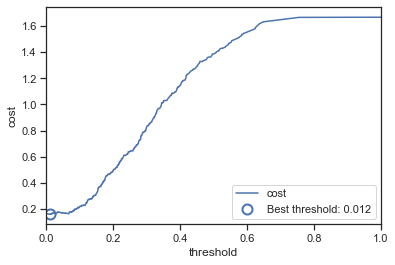

In [42]:
### MODEL SOLUTION
# Cost = cost_FP * FPR * ratio_pos + cost_FN * (1-TPR) * ratio_neg
def cost(fpr, tpr, cost_FN, cost_FP, ratio_P):
    return fpr * cost_FP * ratio_P + (1 - tpr) * (1 - ratio_P) * cost_FN;

# compute
fpr, tpr, thresholds = build_ROC(X, y)
ratio_P = len(y[y==1]) / len(y)
costs = [cost(fpr[x],tpr[x],2,1,ratio_P) for x in range(len(thresholds))]
min_cost = np.argmin(costs)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="threshold", ylabel="cost", xlim=(0,1))
ax.plot(thresholds, costs, c='b', label='cost')
ax.plot(thresholds[min_cost], costs[min_cost], 'o', c='b', markersize=10, 
        label="Best threshold: {}".format(thresholds[min_cost]), fillstyle="none", mew=2)
ax.legend(loc=4);

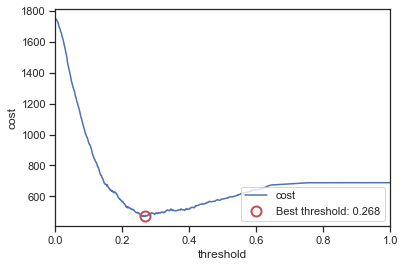

In [43]:
# Alternative: use the actual amount of FP, FN. This is also a feasible measure,
# although the cost then depends on the size of your test set.
# Because this was not specified in the question, both answers are deemed correct
from sklearn.metrics import confusion_matrix

# Cost = cost_FP * FP + cost_FN * FN
def cost2(fp, fn, cost_FN, cost_FP):
    return fp * cost_FP + fn * cost_FN;

# compute
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
pipe = flexible_pipeline(X, RandomForestClassifier(n_estimators=1000, random_state=1), scaler=None, 
                         encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')).fit(X_train,y_train)
proba = pipe.predict_proba(X_test)[:, 1]
# fp and fn can be retrieved from the confusion matrix (or by comparing to the true values ourselves)
# the prediction is true if the probability is above the threshold
fp = [confusion_matrix(y_test,(proba >= t)).ravel()[1] for t in thresholds]
fn = [confusion_matrix(y_test,(proba >= t)).ravel()[2] for t in thresholds]

costs = [cost2(fp[x],fn[x],2,1) for x in range(len(thresholds))]
min_cost = np.argmin(costs)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="threshold", ylabel="cost", xlim=(0,1))
ax.plot(thresholds, costs, label='cost')
ax.plot(thresholds[min_cost], costs[min_cost], 'o', markersize=10, 
        label="Best threshold: {}".format(thresholds[min_cost]), fillstyle="none", c='r', mew=2)
ax.legend(loc=4);

The optimal threshold is now a bit higher. Given the high class imbalance, the rates (FPR,FNR) and counts (FP,FN) 
can be quite different.

## Part 4: Algoritmic bias
Check whether there is any algorithmic bias in the predictions.

### Question 4.1 (3 points)
* Use the same RandomForest pipeline with 1000 trees and `max_features=0.1`
* Use 3-fold stratified cross validation and return the predictions for every fold
* Separate the predictions into different groups depending on the feature 'race', and report the AUC for each group
* Implement a function `plot_4_1` which returns a visualization of these results (e.g. a bar chart)

In [44]:
#Implement
def plot_4_1(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pass

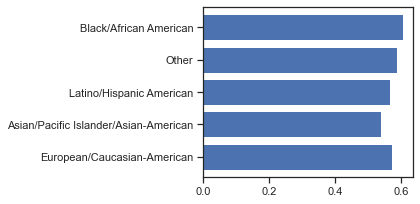

In [45]:
# MODEL SOLUTION
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import cross_val_predict
def plot_4_1(X,y,sample_weights=None):
    pipe = flexible_pipeline(X, RandomForestClassifier(n_estimators=1000, max_features=0.1, random_state=1), scaler=None, 
                             encoder=OneHotEncoder(sparse=False, handle_unknown='ignore'))
    races = X['race'].value_counts().index.to_list()
    if sample_weights: # For Q4.2
        predictions = cross_val_predict(pipe, X, y, cv=3, fit_params={"randomforestclassifier__sample_weight":sample_weights})
    else:
        predictions = cross_val_predict(pipe, X, y, cv=3)

    labels = []
    scores = []
    for r in races:
        labels.append(r)
        scores.append(roc_auc_score(y[X.race == r], predictions[X.race == r]))
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.barh(labels, scores)
    ax.set_yticklabels(labels)
    fig.tight_layout()
    plt.show()
    
    return scores
rscores = plot_4_1(X,y)

### Question 4.2 (3 points)
* Do question 4.1 again, but this time weight the instances with a weight inversely proportional to their frequency.
* Implement a function `plot_4_2` which returns a visualization of these results (e.g. a bar chart)
* Interpret the results and explain them in `answer_q_2_2` (max 400 characters).

In [46]:
#Implement
def plot_4_2(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pass

In [47]:
# MODEL SOLUTION
# Peek at the weights to check if they make sense
race_weights = 100/X['race'].value_counts()
race_weights

European/Caucasian-American              0.021155
Asian/Pacific Islander/Asian-American    0.050454
Latino/Hispanic American                 0.150602
Other                                    0.191571
Black/African American                   0.238095
Name: race, dtype: float64

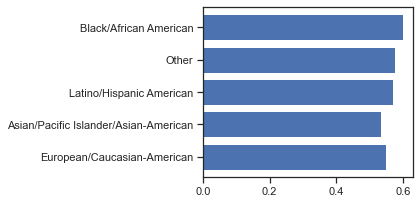

European/Caucasian-American -0.022714737307389488
Asian/Pacific Islander/Asian-American -0.00503488714908118
Latino/Hispanic American 0.003696857670979714
Other -0.009708737864077666
Black/African American -0.005882352941176561


In [48]:
# MODEL SOLUTION
def plot_4_2(X,y):
    # Get weights per sample. We need to impute some nans (replace by majority class)
    race_weights = 100/X['race'].value_counts()
    sample_weights = [race_weights[r if r is not np.nan else 'European/Caucasian-American'] for r in X['race']]
    rscores2 = plot_4_1(X,y,sample_weights=sample_weights)
    
    #print differences
    for i, r in enumerate(race_weights.index.values):
        print(r, rscores2[i] - rscores[i])
        
plot_4_2(X,y)

In [49]:
answer_q_4 = """
               Your answer 
               """
print("Answer is {} characters long".format(len(answer_q_4)))

Answer is 44 characters long


In [50]:
# MODEL SOLUTION
answer_q_4 = """
             The ROC scores are comparable but we can see some differences. The scores of Latinos increased, but at the same time the scores
             for Europeans decreased. Most models have 1% difference. Bias has reduced slightly, but the model
             wasn't very biased to begin with.
             """
print("Answer is {} characters long".format(len(answer_q_4)))

Answer is 225 characters long


In [51]:
print(time.time()-start_time)

746.4958047866821
